# Model situation 1
## Goal:
We want to model a simple market with one normal, one conservative and on risk taking bank, which have different scoring functions and score dependent interest rates. Our aim is to observe the mean score change of borrowers in multiple time steps depending on the institution they choose to borrow from. The decision is based on the borrowers utility, combined with selection rate set by banks based on their utility under different policies. 


# Imports

In [5]:
%load_ext autoreload
%autoreload 2
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import all of our files
import sys
sys.path.append('../')

import fico
import distribution_to_loans_outcomes as dlo
import support_functions as sf

DATA_DIR = '../data/'

# set plotting parameters
sns.set_context("talk")
sns.set_style("white")

# this needs to be here so we can edit figures later
plt.rcParams['pdf.fonttype'] = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


# Variable definition

In [6]:
debug = False

#general market setting
N_banks = 3
bank_names = ["conservative", "normal", "risk taking"]

#score distribution shift
score_shifts = [-20, 0, 40]

#bank interest rate setting
score_range = [300,850]
interest_range_conservative_bank = [0.33, 0.015]
interest_range_normal_bank = [0.27, 0.04]
interest_range_risk_bank = [0.25, 0.1]
interest_rates = [interest_range_conservative_bank, interest_range_normal_bank, interest_range_risk_bank]

# profit and impact
utility_repaid_1 = 1
utility_default_1 = -4
utility_repaid_2 = 1
utility_default_2 = -10

# considering several utility ratios to understand sensitivity of qualitative results
util_repay = [[utility_default_1,utility_repaid_1], [utility_default_2,utility_repaid_2]]

score_change_repay = 75
score_change_default = -150

impact = [score_change_default,score_change_repay]

#policy colors, MU, DP, EO
policy_color = ['green', 'blue', 'red']

#cdf groups
group_names = ["White","Black"]


# 0. Load  data and create customers according to FICO distribution

In [15]:
all_cdfs, performance, totals = fico.get_FICO_data(data_dir=DATA_DIR);
cdfs = all_cdfs[group_names]
cdf_groups = np.transpose(cdfs.values)

repays = performance[group_names]

scores = cdfs.index
scores_list = scores.tolist()
scores_repay = cdfs.index

totals = fico.read_totals(data_dir=DATA_DIR)
group_totals = np.zeros(len(group_names), dtype=np.int32)
for i in range(0,len(group_names)):
    group_totals[i] = int(totals[group_names[i]])

pis = np.zeros(cdf_groups.shape)
customer_totals = np.zeros(len(group_names), dtype=np.int32)

for i in range(0, len(group_names)): 
    pis[i] = sf.get_pmf(cdf_groups[i])
    customer_totals[i] = np.sum(np.round(pis[i]*group_totals[i]))
print("Reference group totals: " + str(group_totals))
print("Calculated group totals: " + str(customer_totals))

pis_total = np.round(pis*group_totals[:, None])

ref_customers = sf.get_ref_customers(customer_totals, pis_total, scores_list)

if debug:
    for i in range(0,len(pis)):
        plt.figure(i)
        plt.plot(scores,pis[i])
        plt.hist(ref_customers[i],50, normed=True)
        plt.ylabel('Fraction/Occurence')
        plt.xlabel('Score')
        plt.title('Fraction and computed customer histogram for '+ group_names[i] + " group.")
        plt.grid()
        plt.legend(loc="upper")
        plt.show()


../fico.py:63: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  cdfs = cleanup_frame(pd.DataFrame.from_csv(data_dir + filenames[0]))
../fico.py:64: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  performance = 100 - cleanup_frame(pd.DataFrame.from_csv(data_dir + filenames[1]))
../fico.py:28: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  frame = cleanup_frame(pd.DataFrame.from_csv(data_dir + FILES['overview']))


Reference group totals: [133165  18274]
Calculated group totals: [133171  18272]


../support_functions.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  step = diff_down/pis_total[i][j]


# 0. Get customer scores and cdfs for different banks

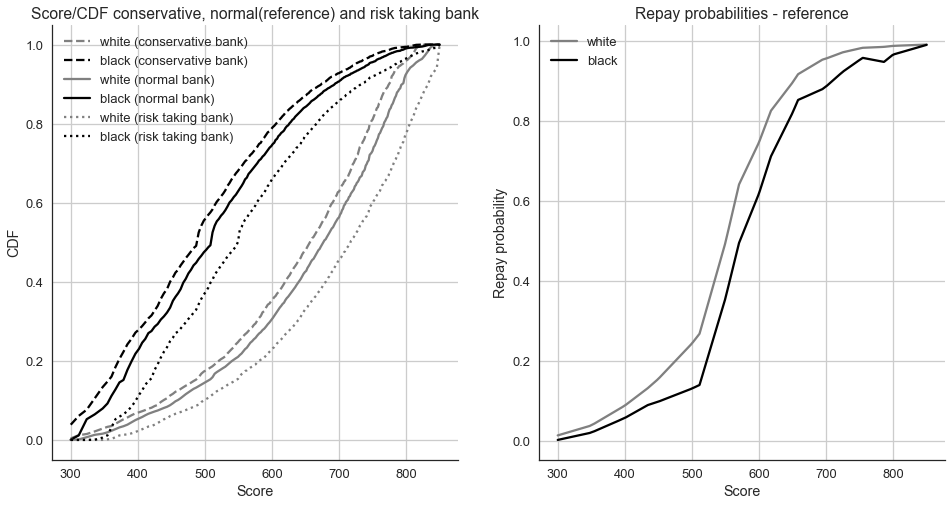

In [16]:
#customers.shape = XxYxZ; X=Groups(white,black), Y=Banks, Z=Individual scores
customer_scores = sf.get_customers(ref_customers, customer_totals, score_shifts, score_range)

#customer_cdfs.shape = XxYxZ, X=Groups, Y=Banks, Z= CDF for score range
customer_cdfs = sf.get_customer_cdfs(customer_scores, scores_list)

fig, ax = plt.subplots(1,2,figsize=(16,8));     
ax[0].plot(scores_list,customer_cdfs[0][0],'--',color="grey", label='white (conservative bank)')
ax[0].plot(scores_list,customer_cdfs[1][0],'--',color='black',label='black (conservative bank)')
ax[0].plot(scores_list,customer_cdfs[0][1],color="grey", label='white (normal bank)')  
ax[0].plot(scores_list,customer_cdfs[1][1],color='black',label='black (normal bank)')
ax[0].plot(scores_list,customer_cdfs[0][2],':',color="grey", label='white (risk taking bank)')
ax[0].plot(scores_list,customer_cdfs[1][2],':',color='black',label='black (risk taking bank)')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_title("Score/CDF conservative, normal(reference) and risk taking bank")
ax[0].set_xlabel("Score")
ax[0].set_ylabel("CDF")
ax[0].legend()
ax[0].grid()


ax[1].plot(scores_list,repays[group_names[0]],label='white',color="grey")
ax[1].plot(scores_list,repays[group_names[1]],color='black',label='black')
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].set_title("Repay probabilities - reference")
ax[1].set_xlabel("Score")
ax[1].set_ylabel("Repay probability")
ax[1].legend()
ax[1].grid()


# 0. Visualize interest rates and compute their intersection

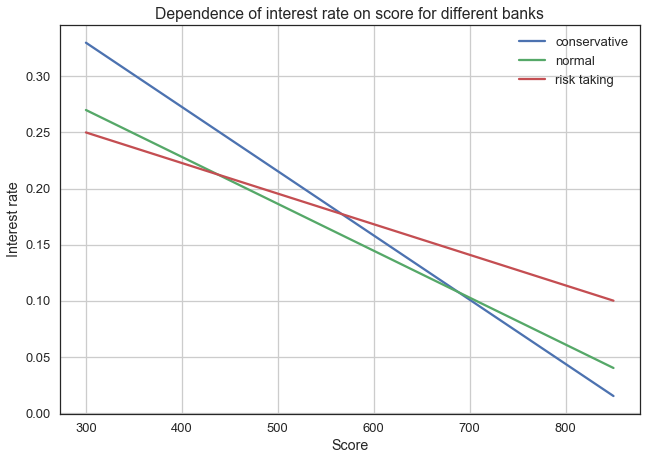

Interest rate intersections: [688.23529411764707, 437.50000000000011, 566.66666666666674]


In [19]:
score_interest_intersect = []    
for i in range(0,N_banks): 
    plt.plot(score_range,interest_rates[i], label=bank_names[i])
    a1= array([score_range[0],interest_rates[i][0]])
    a2= array([score_range[1],interest_rates[i][1]])
    
    if i < N_banks-1:
        b1= array([score_range[0],interest_rates[i+1][0]])
        b2= array([score_range[1],interest_rates[i+1][1]])
    else:
        b1= array([score_range[0],interest_rates[0][0]])
        b2= array([score_range[1],interest_rates[0][1]])
        
    interest_intersect = sf.seg_intersect(a1,a2,b1,b2)
    score_interest_intersect.append(interest_intersect[0])

plt.ylabel('Interest rate')
plt.xlabel('Score')
plt.title('Dependence of interest rate on score for different banks')
plt.grid()
plt.legend(loc="upper right")
plt.show()

print("Interest rate intersections: " + str(score_interest_intersect))

# 1. Get customer utility curve (based on score and i-rate)

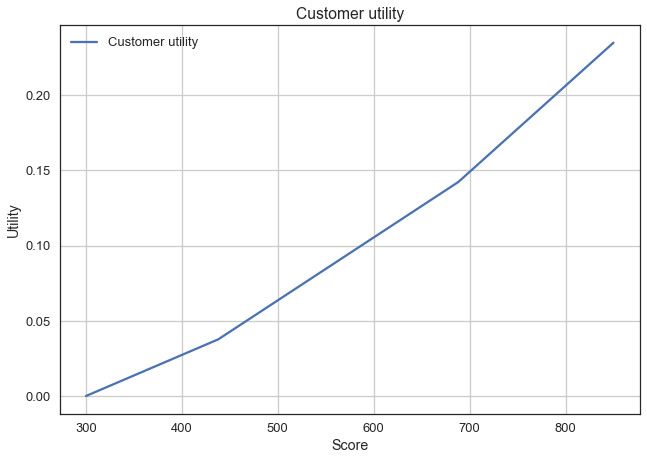

In [53]:
customer_util=[]
for i in range(0,len(interest_rates)):
    slope=(interest_rates[i][1]-interest_rates[i][0])/(score_range[1]-score_range[0])
    tmp_util = [] 
    for j in range(0,score_range[1]-score_range[0]+1):
        tmp_util.append(interest_rates[i][0]+j*slope)
    customer_util.append(tmp_util) 

customer_util = np.amin(customer_util, axis=0)
customer_util = -customer_util+np.max(customer_util)
#print(-customer_util+np.max(customer_util))

plt.plot(range(score_range[0],score_range[1]+1),customer_util, label="Customer utility")
plt.ylabel('Utility')
plt.xlabel('Score')
plt.title('Customer utility')
plt.grid()
plt.legend(loc="upper left")
plt.show()

In [6]:
# to get loan repay probabilities for a given score
loan_repaid_probs = [lambda i: repays[0][scores[scores.get_loc(i,method='nearest')]], 
                     lambda i: repays[1][scores[scores.get_loc(i,method='nearest')]]]

# basic parameters
N_scores = cdf_B1.size
N_groups = 2

# get probability mass functions of each group
pi_A1 = sf.get_pmf(cdf_A1)
pi_B1 = sf.get_pmf(cdf_B1)
pi_A2 = sf.get_pmf(cdf_A2)
pi_B2 = sf.get_pmf(cdf_B2)
pis1 = np.vstack([pi_A1, pi_B1])
pis2 = np.vstack([pi_A2, pi_B2])

plt.figure(1)
plt.plot(scores,pis1[1])

#weighted score
mean = 0
for i in range(0,len(scores)):
    mean += scores[i]*pis1[1][i]
print("weighted mean " + str(mean))


new_pis = sf.get_shifted_score_distributions(pis1, -1, 5)
#weighted score
mean = 0
for i in range(0,len(scores)):
    mean += scores[i]*new_pis[1][i]
print("weighted mean " + str(mean))

plt.plot(scores,new_pis[1])


pi_combined_A = sf.get_pi_combined(pi_A1,pi_A2, scores, score_interest_intersect)
pi_combined_B = sf.get_pi_combined(pi_B1,pi_B2, scores, score_interest_intersect)
pis_combined = np.vstack([pi_combined_A, pi_combined_B])
cdf_combined_A = sf.pis2cdf(pi_combined_A)
cdf_combined_B = sf.pis2cdf(pi_combined_B)

# demographic statistics 
group_ratio = np.array((totals["Black"], totals["White"]))
group_size_ratio = group_ratio/group_ratio.sum()
print(group_size_ratio)

new_cdf=sf.pis2cdf(new_pis[0])
plt.figure(2)
plt.plot(scores, cdf_A1)
plt.plot(scores, new_cdf)

NameError: name 'cdf_B1' is not defined